---
title: "Notebook Clustering: Hierarchical dan K-Means"
author: "Deri Siswara"
format: html
toc: true
---

Pada praktikum ini, kita akan mengeksplorasi dua teknik clustering utama:
1. Hierarchical Clustering (Clustering Hirarki)
2. K-Means Clustering (Clustering Non-Hirarki)

Kemudian kita akan mempelajari bagaimana mengevaluasi hasil clustering menggunakan berbagai metrik.

## 1. Persiapan Data

Pertama, kita impor library yang diperlukan dan menyiapkan dataset untuk analisis clustering. Kita akan menggunakan dataset Mall Customers yang berisi informasi tentang pelanggan di sebuah mall.

In [ ]:
# Import library yang diperlukan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import scipy.cluster.hierarchy as sch
from sklearn.datasets import make_blobs

# Set style plotting
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette('Set2')

# Menetapkan random seed untuk reproduksibilitas
np.random.seed(42)

### 1.1 Load dan Eksplorasi Dataset

Kita akan menggunakan dataset Mall Customers yang berisi informasi tentang pelanggan mall seperti usia, pendapatan, dan skor spending. Dataset ini cocok untuk demonstrasi teknik clustering karena kita ingin menemukan segment pelanggan berdasarkan pola belanja.

**Keterangan Dataset:**

- `CustomerID`: ID Pelanggan

- `Gender`: Jenis Kelamin

- `Age`: Usia

- `Annual Income (k$)`: Pendapatan Tahunan dalam ribuan dolar

- `Spending Score (1-100)`: Skor Belanja (1-100), Skor ini merepresentasikan tingkat loyalitas atau kecenderungan pelanggan dalam berbelanja di mall tersebut. Nilai yang lebih tinggi menunjukkan pelanggan lebih sering dan lebih banyak berbelanja, sedangkan nilai rendah menunjukkan aktivitas belanja yang lebih sedikit.

In [2]:
# Load dataset
url = 'https://raw.githubusercontent.com/SteffiPeTaffy/machineLearningAZ/master/Machine%20Learning%20A-Z%20Template%20Folder/Part%204%20-%20Clustering/Section%2025%20-%20Hierarchical%20Clustering/Mall_Customers.csv'
df = pd.read_csv(url)

# Tampilkan informasi dataset
print("Informasi Dataset:")
print(f"Jumlah baris: {df.shape[0]}")
print(f"Jumlah kolom: {df.shape[1]}")
print("\nLima baris pertama:")
display(df.head())

# Statistik deskriptif
display(df.describe())

# Cek apakah ada missing value
print("\nMissing values:")
display(df.isnull().sum())

Informasi Dataset:
Jumlah baris: 200
Jumlah kolom: 5

Lima baris pertama:


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000



Missing values:


CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

### 1.2 Persiapan Fitur untuk Clustering

Untuk analisis ini, kita akan fokus pada dua fitur: `Annual Income (k$)` dan `Spending Score (1-100)`. Kita akan melakukan standardisasi fitur untuk memastikan bahwa kedua fitur memiliki bobot yang sama dalam analisis clustering.

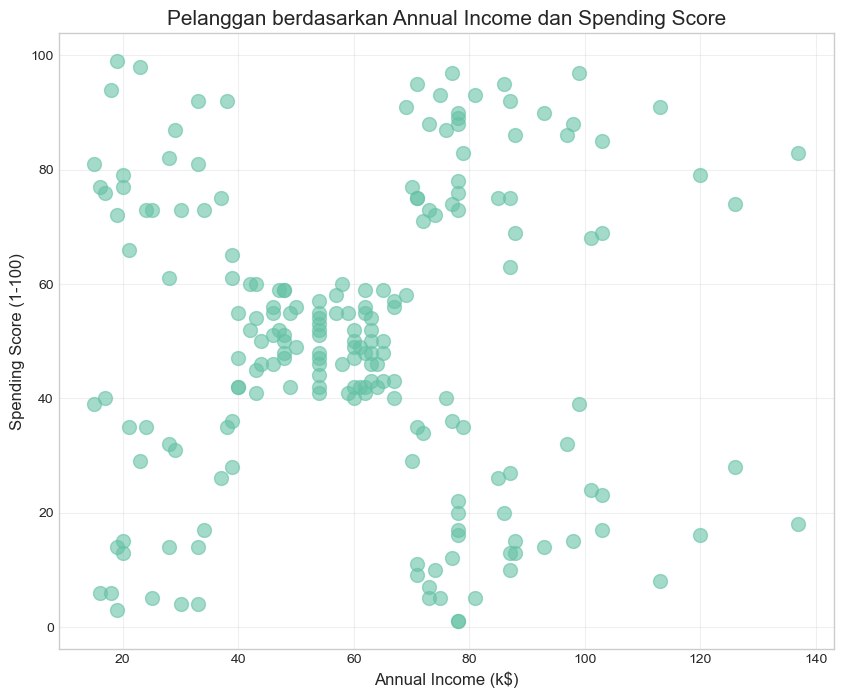

In [3]:
# Memilih fitur yang akan digunakan untuk clustering
X = df.iloc[:, [3, 4]].values  # Annual Income dan Spending Score

# Standardisasi fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Visualisasi data sebelum clustering
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], s=100, alpha=0.6)
plt.title('Pelanggan berdasarkan Annual Income dan Spending Score', fontsize=15)
plt.xlabel('Annual Income (k$)', fontsize=12)
plt.ylabel('Spending Score (1-100)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

## 2. Hierarchical Clustering (Clustering Hirarki)

Hierarchical Clustering membangun hirarki klaster dalam bentuk pohon (dendogram). Ada dua pendekatan utama:

1. **Agglomerative (Bottom-up)**: Dimulai dengan setiap titik data sebagai cluster terpisah dan secara bertahap menggabungkan cluster terdekat.
2. **Divisive (Top-down)**: Dimulai dengan semua titik data dalam satu cluster dan secara bertahap membagi menjadi cluster yang lebih kecil.

Kita akan menggunakan metode Agglomerative karena lebih umum digunakan. Kita juga akan menggunakan metode Ward untuk menghitung jarak antar cluster, yang meminimalkan varians dalam cluster.

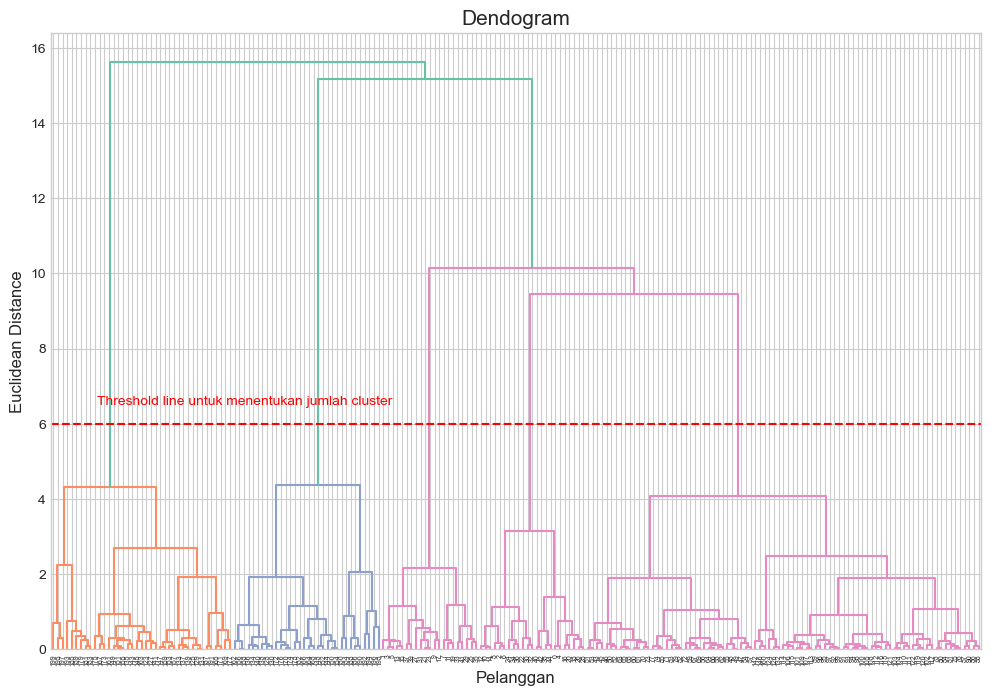

In [4]:
# Membuat dendogram untuk menentukan jumlah optimal cluster
plt.figure(figsize=(12, 8))
dendrogram = sch.dendrogram(sch.linkage(X_scaled, method='ward'))
plt.title('Dendogram', fontsize=15)
plt.xlabel('Pelanggan', fontsize=12)
plt.ylabel('Euclidean Distance', fontsize=12)
plt.axhline(y=6, color='r', linestyle='--')
plt.text(100, 6.5, 'Threshold line untuk menentukan jumlah cluster', color='r')
plt.show()

# Berdasarkan dendogram, kita dapat menentukan jumlah optimal cluster
# Misalnya, jika kita memotong dendogram pada jarak sekitar 6, kita akan mendapatkan 5 cluster

c:\Users\derik\anaconda3\Lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


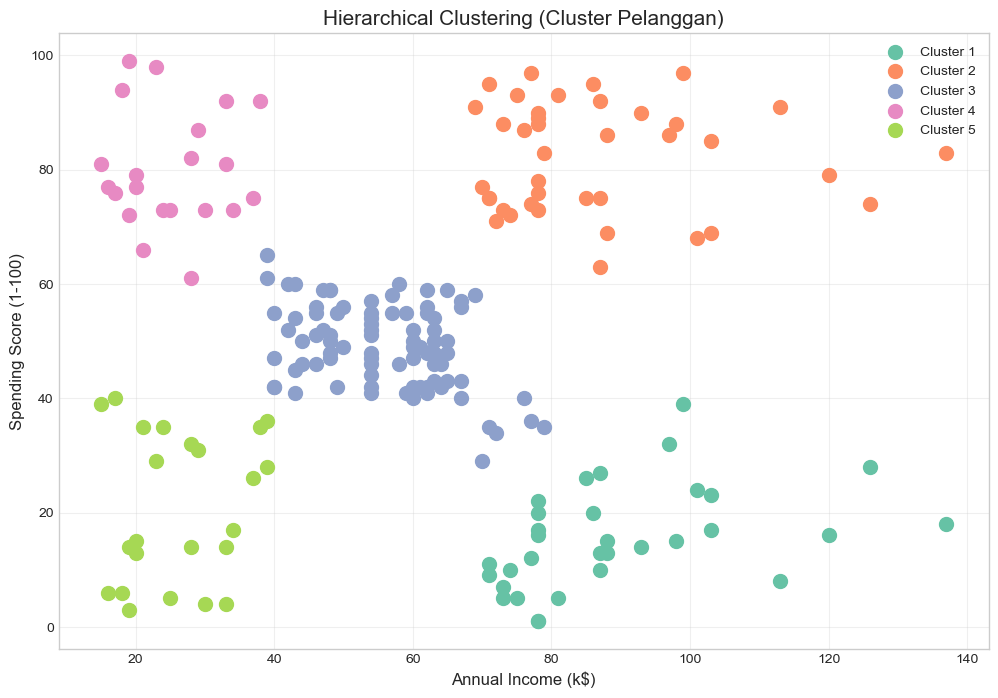

In [5]:
# Implementasi Hierarchical Clustering dengan jumlah cluster yang ditentukan
n_clusters = 5  # Berdasarkan analisis dendogram
hc = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
y_hc = hc.fit_predict(X_scaled)

# Visualisasi hasil Hierarchical Clustering
plt.figure(figsize=(12, 8))
for i in range(n_clusters):
    plt.scatter(X[y_hc == i, 0], X[y_hc == i, 1], s=100, 
                label=f'Cluster {i+1}')

plt.title('Hierarchical Clustering (Cluster Pelanggan)', fontsize=15)
plt.xlabel('Annual Income (k$)', fontsize=12)
plt.ylabel('Spending Score (1-100)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 2.1 Analisis Hasil Hierarchical Clustering

Mari kita analisis hasil hierarchical clustering dengan menghitung statistik untuk setiap cluster dan mendeskripsikan karakteristik masing-masing segmen pelanggan.

Statistik Cluster Hirarki:


Age                    Annual Income (k$)      \
                           mean min max        std               mean min   
Hierarchical_Cluster                                                        
0                     41.000000  19  59  11.036596          89.406250  71   
1                     32.692308  27  40   3.728650          86.538462  69   
2                     42.482353  18  70  16.395856          55.811765  39   
3                     25.333333  18  35   5.378971          25.095238  15   
4                     45.217391  19  67  13.228607          26.304348  15   

                                     Spending Score (1-100)                     
                      max        std                   mean min max        std  
Hierarchical_Cluster                                                            
0                     137  16.612975              15.593750   1  39   8.936548  
1                     137  16.312485              82.128205  63  97   9.364489  
2                      79   9.731508              49.129412  29  65   7.281399  
3                      38   7.133756              80.047619  61  99  10.249274  
4                      39   7.893811              20.913043   3  40  13.017167

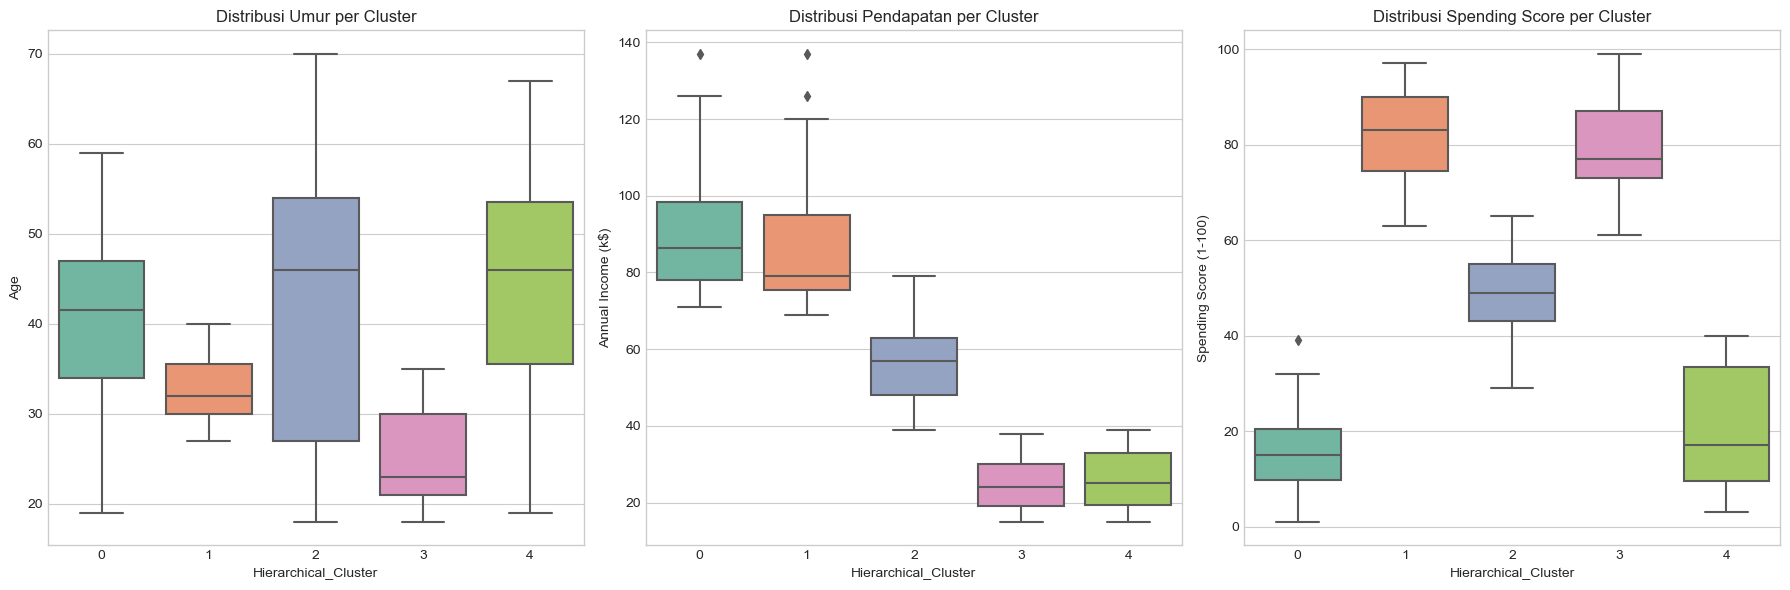

In [6]:
# Menambahkan hasil cluster ke dataframe
df['Hierarchical_Cluster'] = y_hc

# Menghitung statistik untuk setiap cluster
cluster_stats = df.groupby('Hierarchical_Cluster').agg({
    'Age': ['mean', 'min', 'max', 'std'],
    'Annual Income (k$)': ['mean', 'min', 'max', 'std'],
    'Spending Score (1-100)': ['mean', 'min', 'max', 'std'],
})

print("Statistik Cluster Hirarki:")
display(cluster_stats)

# Visualisasi distribusi umur, pendapatan, dan spending score di setiap cluster
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot distribusi umur
sns.boxplot(x='Hierarchical_Cluster', y='Age', data=df, ax=axes[0])
axes[0].set_title('Distribusi Umur per Cluster')

# Plot distribusi pendapatan
sns.boxplot(x='Hierarchical_Cluster', y='Annual Income (k$)', data=df, ax=axes[1])
axes[1].set_title('Distribusi Pendapatan per Cluster')

# Plot distribusi spending score
sns.boxplot(x='Hierarchical_Cluster', y='Spending Score (1-100)', data=df, ax=axes[2])
axes[2].set_title('Distribusi Spending Score per Cluster')

plt.tight_layout()
plt.show()

## 3. K-Means Clustering (Clustering Non-Hirarki)

K-Means adalah algoritma clustering non-hirarki yang populer karena kesederhanaan dan efisiensinya. K-Means bekerja dengan membagi data menjadi K klaster dengan meminimalkan jarak antara titik data dan pusat klaster (centroid).

Langkah-langkah algoritma K-Means:
1. Inisialisasi K centroid secara acak
2. Tetapkan setiap titik data ke centroid terdekat (membentuk cluster)
3. Hitung ulang centroid sebagai rata-rata titik data dalam cluster
4. Ulangi langkah 2-3 hingga centroid tidak berubah signifikan

Tantangan utama dalam K-Means adalah menentukan jumlah K yang optimal. Kita akan menggunakan metode Elbow untuk ini.

c:\Users\derik\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\derik\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\derik\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\derik\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

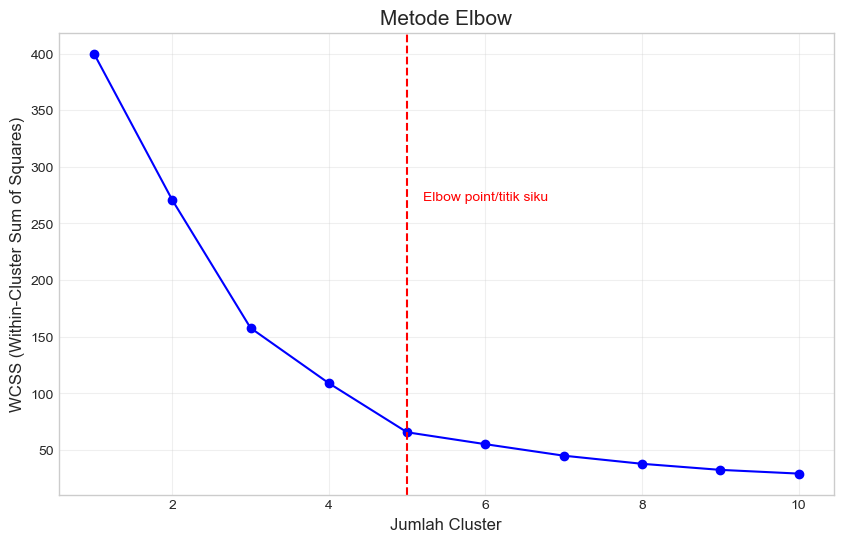

In [7]:
# Metode Elbow untuk menentukan jumlah optimal cluster
wcss = []  # Within-Cluster Sum of Squares
max_clusters = 10

for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Visualisasi metode Elbow
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='-', color='blue')
plt.title('Metode Elbow', fontsize=15)
plt.xlabel('Jumlah Cluster', fontsize=12)
plt.ylabel('WCSS (Within-Cluster Sum of Squares)', fontsize=12)
plt.axvline(x=5, color='r', linestyle='--')
plt.text(5.2, wcss[1], 'Elbow point/titik siku', color='r')
plt.grid(True, alpha=0.3)
plt.show()

c:\Users\derik\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


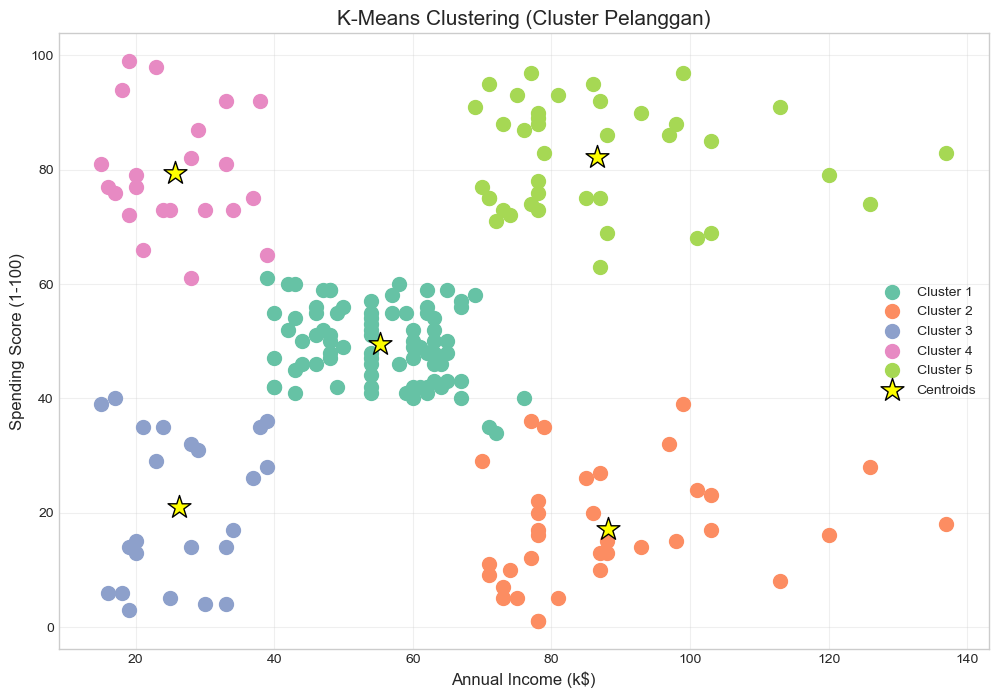

In [8]:
# Implementasi K-Means dengan jumlah optimal cluster
n_clusters = 5  # Berdasarkan metode Elbow
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
y_kmeans = kmeans.fit_predict(X_scaled)
centroids = scaler.inverse_transform(kmeans.cluster_centers_)

# Visualisasi hasil K-Means Clustering
plt.figure(figsize=(12, 8))
for i in range(n_clusters):
    plt.scatter(X[y_kmeans == i, 0], X[y_kmeans == i, 1], s=100, 
                label=f'Cluster {i+1}')

plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='yellow', 
            marker='*', edgecolors='black', label='Centroids')
plt.title('K-Means Clustering (Cluster Pelanggan)', fontsize=15)
plt.xlabel('Annual Income (k$)', fontsize=12)
plt.ylabel('Spending Score (1-100)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 3.1 Analisis Hasil K-Means Clustering

Mari kita analisis hasil K-Means clustering dan bandingkan hasilnya dengan Hierarchical clustering.

Statistik Cluster K-Means:


Age                    Annual Income (k$)           \
                     mean min max        std               mean min  max   
KMeans_Cluster                                                             
0               42.716049  18  70  16.447822          55.296296  39   76   
1               41.114286  19  59  11.341676          88.200000  70  137   
2               45.217391  19  67  13.228607          26.304348  15   39   
3               25.272727  18  35   5.257030          25.727273  15   39   
4               32.692308  27  40   3.728650          86.538462  69  137   

                          Spending Score (1-100)                     
                      std                   mean min max        std  
KMeans_Cluster                                                       
0                8.988109              49.518519  34  61   6.530909  
1               16.399067              17.114286   1  39   9.952154  
2                7.893811              20.913043   3  40  13.017167  
3                7.566731              79.363636  61  99  10.504174  
4               16.312485              82.128205  63  97   9.364489

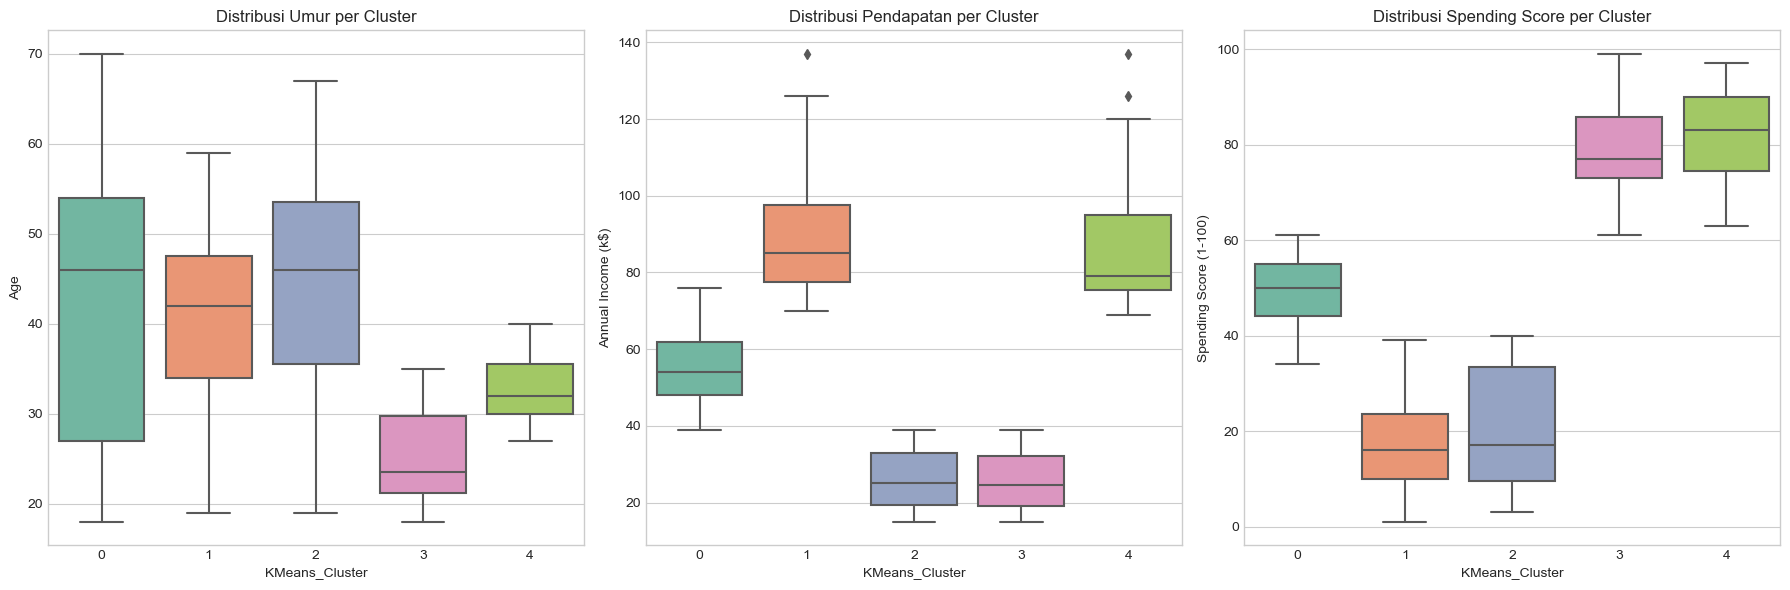

In [9]:
# Menambahkan hasil cluster ke dataframe
df['KMeans_Cluster'] = y_kmeans

# Menghitung statistik untuk setiap cluster
cluster_stats_kmeans = df.groupby('KMeans_Cluster').agg({
    'Age': ['mean', 'min', 'max', 'std'],
    'Annual Income (k$)': ['mean', 'min', 'max', 'std'],
    'Spending Score (1-100)': ['mean', 'min', 'max', 'std'],
})

print("Statistik Cluster K-Means:")
display(cluster_stats_kmeans)

# Visualisasi distribusi umur, pendapatan, dan spending score di setiap cluster
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot distribusi umur
sns.boxplot(x='KMeans_Cluster', y='Age', data=df, ax=axes[0])
axes[0].set_title('Distribusi Umur per Cluster')

# Plot distribusi pendapatan
sns.boxplot(x='KMeans_Cluster', y='Annual Income (k$)', data=df, ax=axes[1])
axes[1].set_title('Distribusi Pendapatan per Cluster')

# Plot distribusi spending score
sns.boxplot(x='KMeans_Cluster', y='Spending Score (1-100)', data=df, ax=axes[2])
axes[2].set_title('Distribusi Spending Score per Cluster')

plt.tight_layout()
plt.show()

## 4. Evaluasi Clustering

Evaluasi hasil clustering adalah tahap penting untuk menilai kualitas cluster yang dihasilkan. Karena clustering adalah pembelajaran tanpa pengawasan (unsupervised learning), kita tidak memiliki label yang benar untuk dievaluasi. Oleh karena itu, kita menggunakan metrik internal yang mengukur seberapa baik data terkelompok.

Beberapa metrik evaluasi umum:

1. **Silhouette Coefficient**: Mengukur seberapa mirip objek dengan clusternya sendiri dibandingkan dengan cluster lain. Nilai berkisar antara -1 hingga 1, di mana nilai yang lebih tinggi menunjukkan clustering yang lebih baik.

2. **Calinski-Harabasz Index**: Juga dikenal sebagai Variance Ratio Criterion, menghitung rasio dispersi antar cluster dan dalam cluster. Nilai yang lebih tinggi menunjukkan cluster yang lebih terpisah dengan baik.

3. **Davies-Bouldin Index**: Mengukur jarak rata-rata antara setiap cluster dan cluster yang paling mirip dengannya. Nilai yang lebih rendah menunjukkan clustering yang lebih baik.

In [10]:
# Fungsi untuk mengevaluasi dan membandingkan hasil clustering
def evaluate_clustering(X, labels, method_name):
    silhouette = silhouette_score(X, labels)
    calinski = calinski_harabasz_score(X, labels)
    davies = davies_bouldin_score(X, labels)
    
    print(f"Evaluasi untuk {method_name}:")
    print(f"Silhouette Score: {silhouette:.4f} (semakin tinggi semakin baik, range [-1, 1])")
    print(f"Calinski-Harabasz Index: {calinski:.4f} (semakin tinggi semakin baik)")
    print(f"Davies-Bouldin Index: {davies:.4f} (semakin rendah semakin baik)")
    print("-" * 50)
    
    return silhouette, calinski, davies

# Evaluasi hasil Hierarchical Clustering
sil_hc, cal_hc, dav_hc = evaluate_clustering(X_scaled, y_hc, "Hierarchical Clustering")

# Evaluasi hasil K-Means Clustering
sil_km, cal_km, dav_km = evaluate_clustering(X_scaled, y_kmeans, "K-Means Clustering")

Evaluasi untuk Hierarchical Clustering:
Silhouette Score: 0.5538 (semakin tinggi semakin baik, range [-1, 1])
Calinski-Harabasz Index: 244.4103 (semakin tinggi semakin baik)
Davies-Bouldin Index: 0.5779 (semakin rendah semakin baik)
--------------------------------------------------
Evaluasi untuk K-Means Clustering:
Silhouette Score: 0.5547 (semakin tinggi semakin baik, range [-1, 1])
Calinski-Harabasz Index: 248.6493 (semakin tinggi semakin baik)
Davies-Bouldin Index: 0.5722 (semakin rendah semakin baik)
--------------------------------------------------


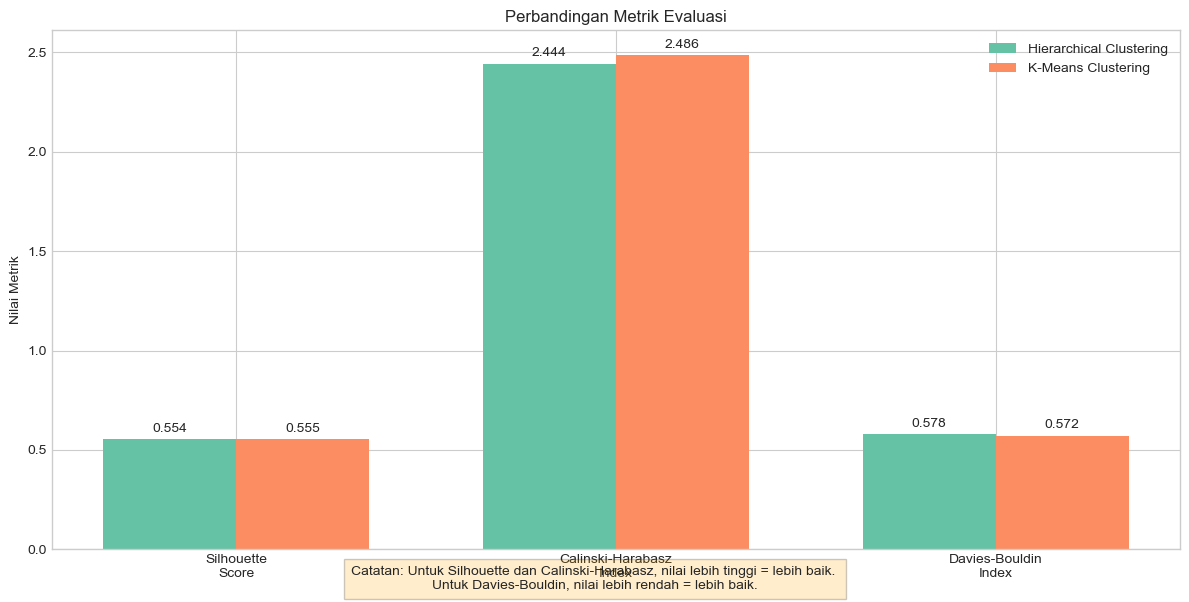

In [11]:
# Visualisasi perbandingan metrik evaluasi
metrics = ['Silhouette\nScore', 'Calinski-Harabasz\nIndex', 'Davies-Bouldin\nIndex']
hc_scores = [sil_hc, cal_hc/100, dav_hc]  # Scaling untuk visualisasi yang lebih baik
km_scores = [sil_km, cal_km/100, dav_km]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, hc_scores, width, label='Hierarchical Clustering')
rects2 = ax.bar(x + width/2, km_scores, width, label='K-Means Clustering')

ax.set_ylabel('Nilai Metrik')
ax.set_title('Perbandingan Metrik Evaluasi')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Menambahkan label nilai pada bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Tambahkan catatan untuk interpretasi
plt.figtext(0.5, 0.01, 
            'Catatan: Untuk Silhouette dan Calinski-Harabasz, nilai lebih tinggi = lebih baik. \nUntuk Davies-Bouldin, nilai lebih rendah = lebih baik.', 
            ha='center', fontsize=10, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})

plt.tight_layout()
plt.show()

## 5. Studi Kasus: Segmentasi Pelanggan

Berdasarkan hasil clustering, mari kita interpretasikan segmen pelanggan yang telah kita identifikasi. Segmentasi pelanggan adalah salah satu aplikasi clustering yang paling umum dalam bisnis, memungkinkan strategi pemasaran yang lebih ditargetkan.

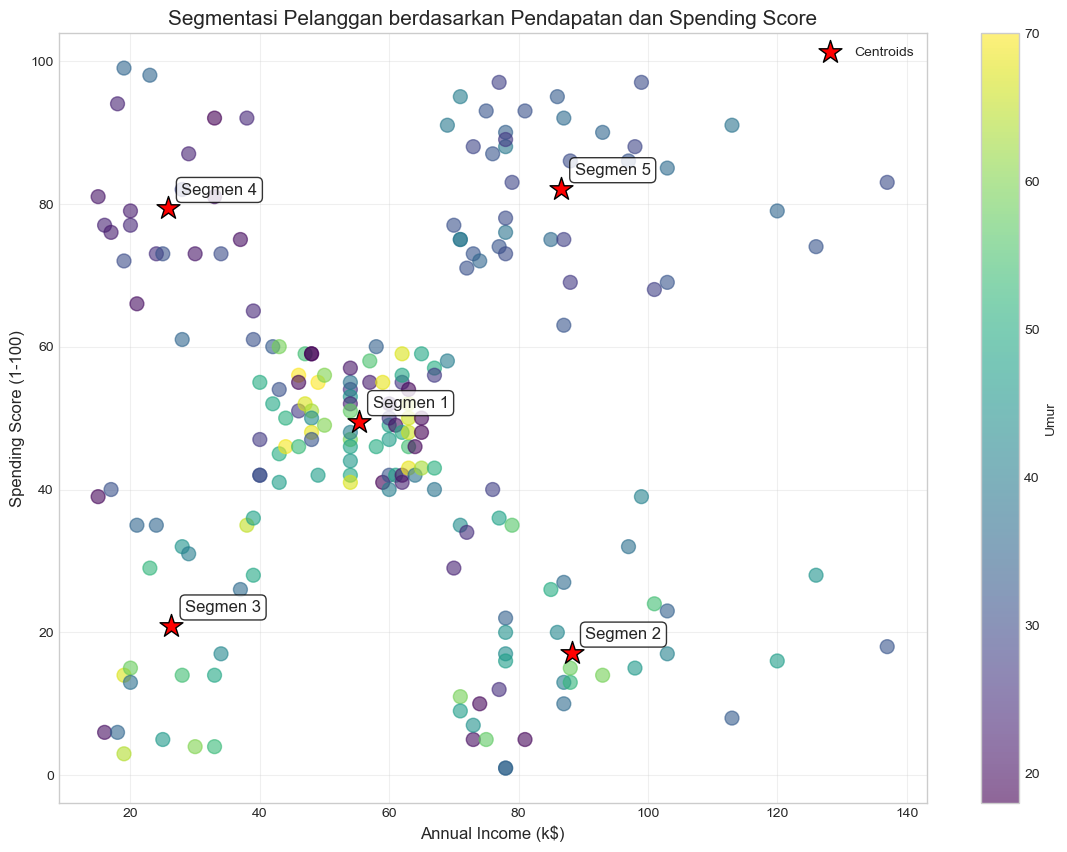

In [12]:
# Visualisasi scatter plot dengan ketiga fitur (menggunakan warna untuk umur)
plt.figure(figsize=(14, 10))

scatter = plt.scatter(X[:, 0], X[:, 1], c=df['Age'], s=100, alpha=0.6, cmap='viridis')
plt.colorbar(scatter, label='Umur')

# Menambahkan centroid K-Means
plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='red', 
            marker='*', edgecolors='black', label='Centroids')

# Menambahkan anotasi untuk segmen
for i, centroid in enumerate(centroids):
    plt.annotate(f'Segmen {i+1}', 
                 (centroid[0], centroid[1]),
                 xytext=(10, 10),
                 textcoords='offset points',
                 fontsize=12,
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))

plt.title('Segmentasi Pelanggan berdasarkan Pendapatan dan Spending Score', fontsize=15)
plt.xlabel('Annual Income (k$)', fontsize=12)
plt.ylabel('Spending Score (1-100)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Jumlah Pelanggan per Segmen:
Segmen 0 - Pelanggan dengan pendapatan tinggi dan spending score tinggi (Target Utama): 81 pelanggan
Segmen 1 - Pelanggan dengan pendapatan rendah dan spending score rendah (Pelanggan Hemat): 35 pelanggan
Segmen 2 - Pelanggan dengan pendapatan tinggi tapi spending score rendah (Potensial Tidak Terealisasi): 23 pelanggan
Segmen 3 - Pelanggan dengan pendapatan rendah tapi spending score tinggi (Loyal Tapi Terbatas): 22 pelanggan
Segmen 4 - Pelanggan dengan pendapatan dan spending score rata-rata (Pelanggan Biasa): 39 pelanggan


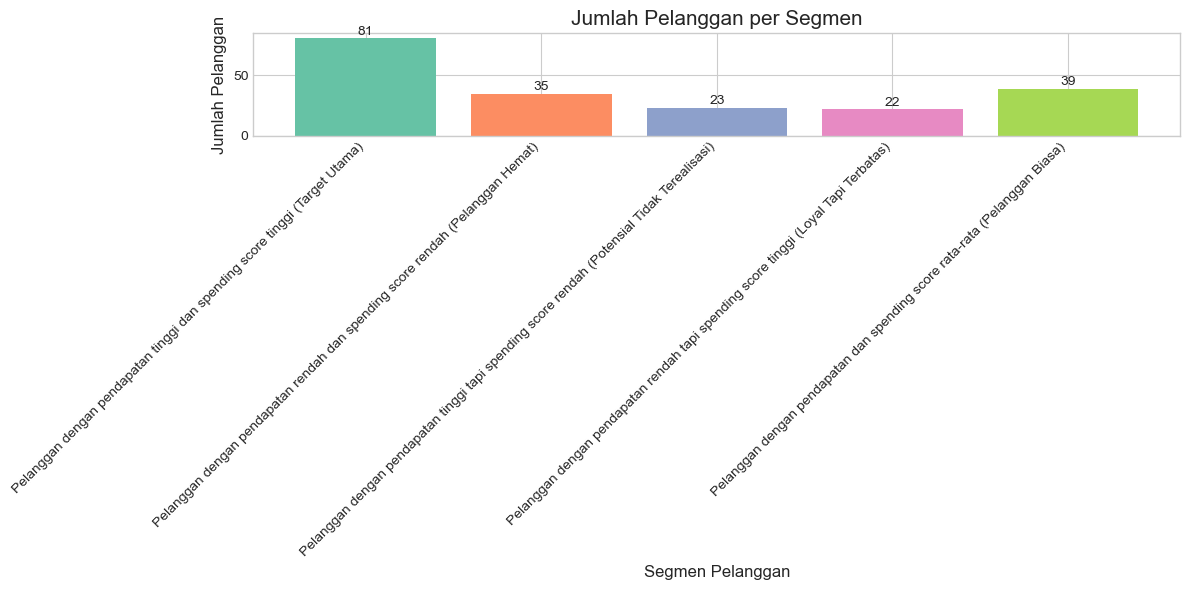

In [13]:
# Deskripsi segmen pelanggan
segment_descriptions = {
    0: "Pelanggan dengan pendapatan tinggi dan spending score tinggi (Target Utama)",
    1: "Pelanggan dengan pendapatan rendah dan spending score rendah (Pelanggan Hemat)",
    2: "Pelanggan dengan pendapatan tinggi tapi spending score rendah (Potensial Tidak Terealisasi)",
    3: "Pelanggan dengan pendapatan rendah tapi spending score tinggi (Loyal Tapi Terbatas)",
    4: "Pelanggan dengan pendapatan dan spending score rata-rata (Pelanggan Biasa)"
}

# Menambahkan deskripsi segmen ke DataFrame
df['Segment_Description'] = df['KMeans_Cluster'].map(segment_descriptions)

# Menampilkan jumlah pelanggan di setiap segmen
segment_counts = df['KMeans_Cluster'].value_counts().sort_index()
print("Jumlah Pelanggan per Segmen:")
for i, count in enumerate(segment_counts):
    print(f"Segmen {i} - {segment_descriptions[i]}: {count} pelanggan")

# Visualisasi jumlah pelanggan per segmen
plt.figure(figsize=(12, 6))
bars = plt.bar(segment_descriptions.values(), segment_counts, color=sns.color_palette("Set2"))

# Menambahkan label jumlah pada setiap bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height}',
             ha='center', va='bottom')

plt.title('Jumlah Pelanggan per Segmen', fontsize=15)
plt.xlabel('Segmen Pelanggan', fontsize=12)
plt.ylabel('Jumlah Pelanggan', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 6. Kesimpulan

Dalam praktikum ini, kita telah mempelajari:

1. **Hierarchical Clustering**:
   - Membangun dendogram untuk menentukan jumlah cluster optimal
   - Menggunakan metode Ward untuk menghitung jarak antar cluster
   - Visualisasi dan interpretasi hasil

2. **K-Means Clustering**:
   - Menggunakan metode Elbow untuk menentukan jumlah cluster optimal
   - Implementasi dan visualisasi K-Means clustering
   - Interpretasi centroid cluster

3. **Evaluasi Clustering**:
   - Menggunakan Silhouette Score, Calinski-Harabasz Index, dan Davies-Bouldin Index
   - Membandingkan kinerja berbagai metode clustering
   
4. **Segmentasi Pelanggan**:
   - Mengidentifikasi dan mendeskripsikan segmen pelanggan berdasarkan pendapatan dan spending score
   - Memberikan implikasi bisnis untuk setiap segmen

Teknik clustering sangat berguna dalam berbagai aplikasi bisnis, terutama untuk segmentasi pelanggan, yang memungkinkan strategi pemasaran yang lebih ditargetkan dan personalisasi produk/layanan yang lebih baik.